In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
df=pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Data preprocessing

In [5]:
df.shape

(20640, 10)

In [6]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
df.total_rooms.mean()

2635.7630813953488

In [11]:
df.total_bedrooms.mean()


537.8705525375618

In [10]:
df.total_bedrooms.median()

435.0

In [12]:
df.total_bedrooms.mode()

0    280.0
Name: total_bedrooms, dtype: float64

In [13]:
# Select only numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64'])

# Create a dictionary to hold outlier info
outliers_dict = {}

# Loop through each numerical column
for col in numerical_cols.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_dict[col] = outliers.shape[0]

# Display outliers count per column
for col, count in outliers_dict.items():
    print(f"{col}: {count} outliers")


longitude: 0 outliers
latitude: 0 outliers
housing_median_age: 0 outliers
total_rooms: 1287 outliers
total_bedrooms: 1271 outliers
population: 1196 outliers
households: 1220 outliers
median_income: 681 outliers
median_house_value: 1071 outliers


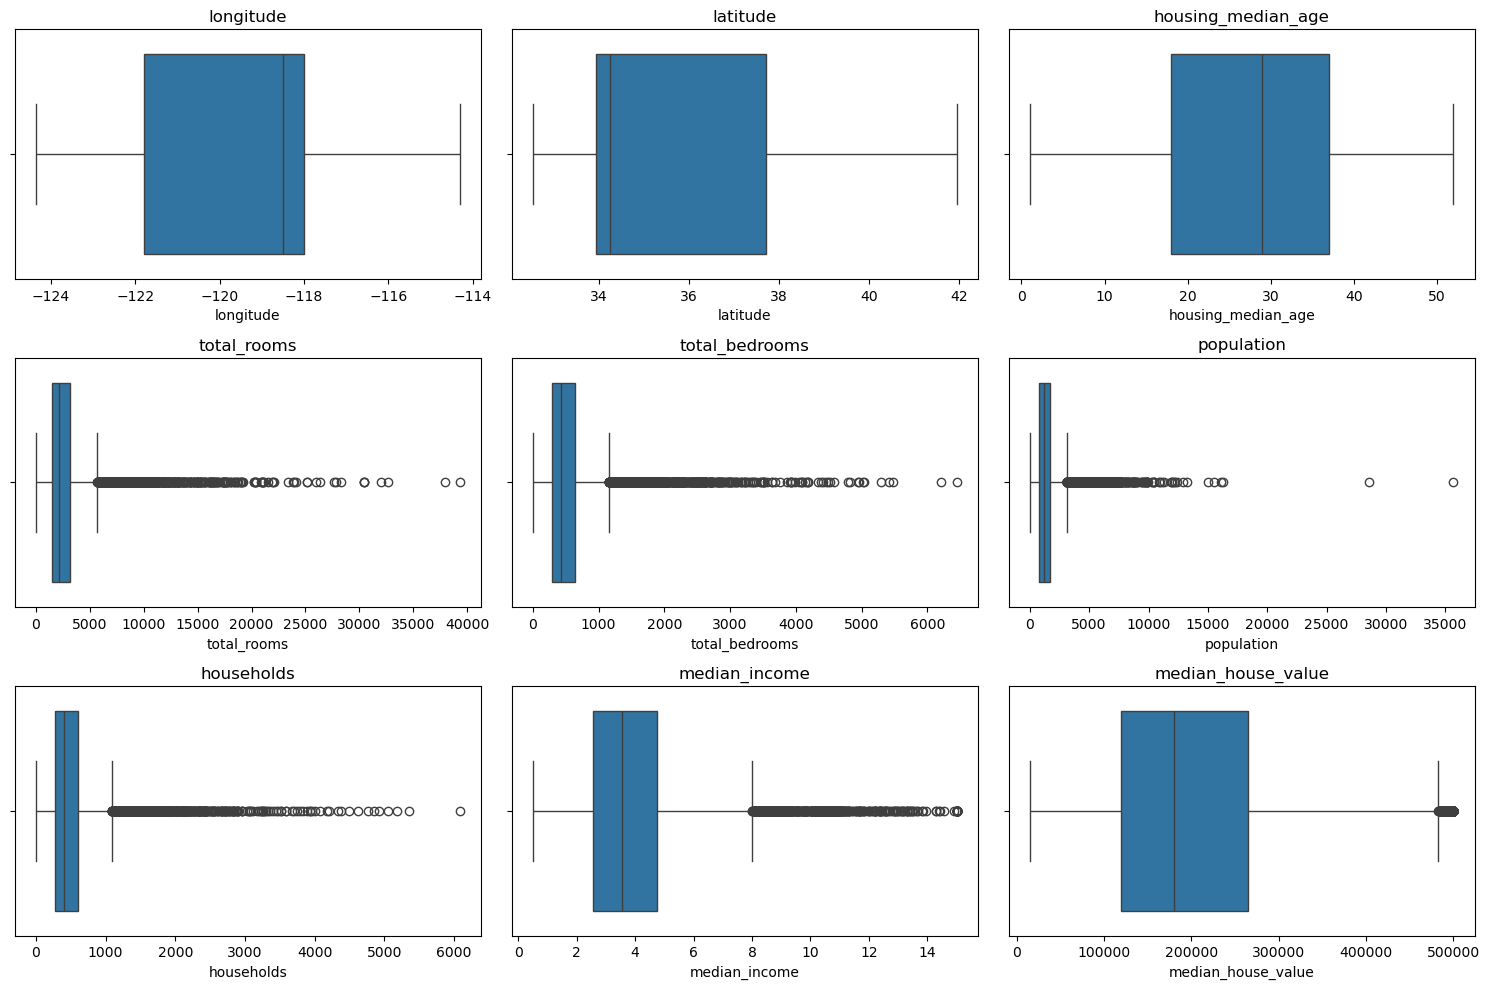

In [17]:
import seaborn as sns

# Plot boxplots for all numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.tight_layout()
plt.show()


In [15]:
#Imputing missing values in total_bedrooms using median
#since total_bedrooms has outliers and median is robust to outliers.

df.total_bedrooms=df.total_bedrooms.fillna(df.total_bedrooms.median())
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Developing models

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


X = df.drop('median_house_value',axis='columns')
y = df.median_house_value

# Define categorical columns
categorical_cols = ['ocean_proximity']

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keep other columns as they are
)

# Apply transformation
X_encoded = preprocessor.fit_transform(X)

# Now you can safely fit your model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [22]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_linear = lin_reg.predict(X_test)


In [23]:
# Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

In [24]:
# Lasso Regression
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.263e+12, tolerance: 2.207e+10
  model = cd_fast.enet_coordinate_descent(


🔹 Linear Regression:
R² Score: 0.6254240620553772
RMSE: 70060.52184473364

🔹 Ridge Regression:
R² Score: 0.625320556819369
RMSE: 70070.20096347661

🔹 Lasso Regression:
R² Score: 0.6254223354293273
RMSE: 70060.68331824332


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


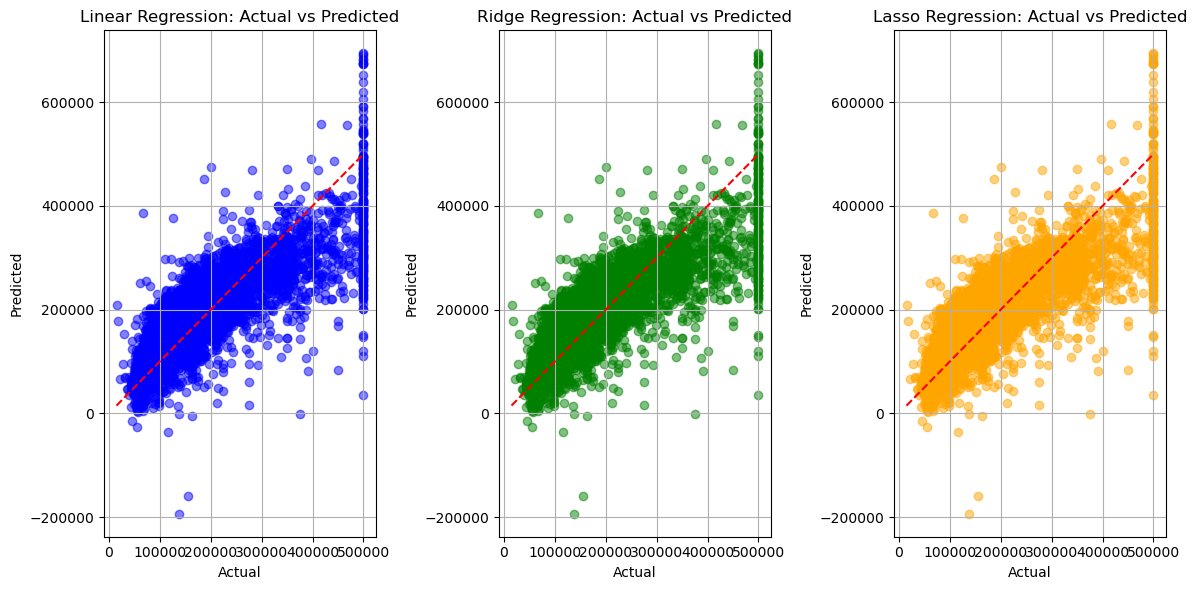

In [25]:

# Metrics
print("🔹 Linear Regression:")
print("R² Score:", r2_score(y_test, y_pred_linear))
print("RMSE:", mean_squared_error(y_test, y_pred_linear, squared=False))

print("\n🔹 Ridge Regression:")
print("R² Score:", r2_score(y_test, y_pred_ridge))
print("RMSE:", mean_squared_error(y_test, y_pred_ridge, squared=False))

print("\n🔹 Lasso Regression:")
print("R² Score:", r2_score(y_test, y_pred_lasso))
print("RMSE:", mean_squared_error(y_test, y_pred_lasso, squared=False))

# Plot comparison
plt.figure(figsize=(12, 6))

# Linear Regression Plot
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_linear, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# Ridge Regression Plot
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_ridge, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Ridge Regression: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# Lasso Regression Plot
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_lasso, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Lasso Regression: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()
